In [2]:
from ga4stpg.tree.pxpartition import PartitionCrossoverSteinerTree as PSTX

In [3]:
from os import path
from pprint import pprint
from ga4stpg.graph import UGraph
from ga4stpg.graph.reader import ReaderORLibrary
from ga4stpg.graph.util import is_steiner_tree

instance_problem = "steinb5.txt"
folder_datasets = path.join('..', '..', 'ppgi-stpg-gpx', 'datasets', 'ORLibrary')
filename = path.join(folder_datasets, instance_problem)

STPG = ReaderORLibrary().parser(filename)

In [4]:
print("STPG information", '\n', 10*'- ','\n')
print('Instance: ', STPG.name)
print("Nro. Node:", STPG.nro_nodes)
print("Nro. Edges:", STPG.nro_edges)
print("Nro. Terminals:", STPG.nro_terminals)
print("Terminals: \n", STPG.terminals)

STPG information 
 - - - - - - - - - -  

Instance:  B5
Nro. Node: 50
Nro. Edges: 100
Nro. Terminals: 13
Terminals: 
 {3, 35, 5, 37, 7, 39, 13, 15, 16, 20, 23, 24, 31}


In [5]:
from ga4stpg.tree.evaluation import EvaluateTreeGraph
from ga4stpg.tree.generate import GenerateBasedRandomWalk
from ga4stpg.tree.mutate import Prunning

generator = GenerateBasedRandomWalk(STPG)
evaluator = EvaluateTreeGraph(STPG)
prunning  = Prunning(STPG)

red  = generator()
blue = generator()

print(evaluator(red))
print(evaluator(blue))

(244, 1)
(256, 1)


In [6]:
red = prunning(red)
blue = prunning(blue)

print(evaluator(red))
print(evaluator(blue))

(147, 1)
(135, 1)


In [7]:
crossover = PSTX(STPG)

In [8]:
child     = UGraph()
red_only  = UGraph()
blue_only = UGraph()

for v, u in red.gen_undirect_edges():
    if blue.has_edge(v, u):
        child.add_edge(v, u)
    else:
        red_only.add_edge(v, u)

for v, u in blue.gen_undirect_edges():
    if not red.has_edge(v, u):
        blue_only.add_edge(v, u)

common_nodes_red = set(red_only.vertices) & set(blue.vertices)
common_nodes_blue = set(blue_only.vertices) & set(red.vertices)

red_partitions  = crossover.find_partitions(red_only, common_nodes_red)
blue_partitions = crossover.find_partitions(blue_only, common_nodes_blue)

In [9]:
common_nodes_blue == common_nodes_red

False

In [10]:
g_union = UGraph()

for v, u in red.gen_undirect_edges():
    g_union.add_edge(v, u)

for v, u in blue.gen_undirect_edges():
    g_union.add_edge(v, u)

In [11]:
vertices = common_nodes_red | common_nodes_blue

vertices |= set(child.vertices)

vertices

{3,
 4,
 5,
 6,
 7,
 10,
 13,
 15,
 16,
 20,
 21,
 23,
 24,
 25,
 26,
 31,
 35,
 37,
 39,
 40,
 42,
 48}

In [12]:
from ga4stpg.graph.disjointsets import DisjointSets

disjoint = DisjointSets()

for v in vertices:
    disjoint.make_set(v)

for v, u in child.gen_undirect_edges():
    disjoint.union(v, u)

In [13]:
len(disjoint.get_disjoint_sets()), len(vertices)

(11, 22)

In [14]:
red_partitions

[Partition <{26, 31}>,
 Partition <{25, 5}>,
 Partition <{24, 42, 7}>,
 Partition <{42, 23}>,
 Partition <{21, 6}>,
 Partition <{35, 20, 4}>,
 Partition <{4, 15}>,
 Partition <{3, 39}>]

In [15]:
blue_partitions

[Partition <{23, 31}>,
 Partition <{10, 23}>,
 Partition <{25, 15}>,
 Partition <{35, 21, 7}>,
 Partition <{3, 21}>,
 Partition <{37, 21}>,
 Partition <{20, 37}>,
 Partition <{48, 5}>,
 Partition <{42, 6}>]

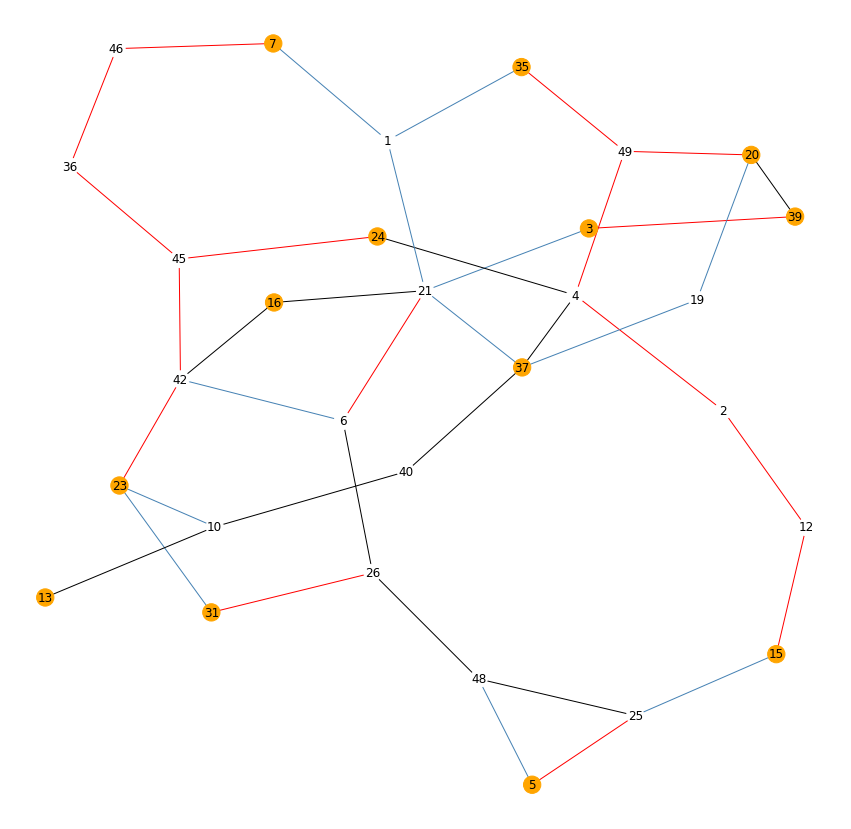

In [16]:
from draw import draw_common
from matplotlib import pyplot as plt

plt.figure(figsize=(15,15))

draw_common(g_union, STPG.terminals, red, blue)

In [17]:
def matches_from(partitions):
    matches = dict()
    for partition in partitions:
        key = frozenset(disjoint.find(v) for v in partition.portal)
        matches[key] = partition
    return matches

In [18]:
red_matches = matches_from(red_partitions)
blue_matches = matches_from(blue_partitions)

In [19]:
red_matches

{frozenset({26, 31}): Partition <{26, 31}>,
 frozenset({5, 26}): Partition <{25, 5}>,
 frozenset({7, 16, 24}): Partition <{24, 42, 7}>,
 frozenset({16, 23}): Partition <{42, 23}>,
 frozenset({16, 26}): Partition <{21, 6}>,
 frozenset({20, 24, 35}): Partition <{35, 20, 4}>,
 frozenset({15, 24}): Partition <{4, 15}>,
 frozenset({3, 20}): Partition <{3, 39}>}

In [20]:
blue_matches

{frozenset({23, 31}): Partition <{23, 31}>,
 frozenset({23, 24}): Partition <{10, 23}>,
 frozenset({15, 26}): Partition <{25, 15}>,
 frozenset({7, 16, 35}): Partition <{35, 21, 7}>,
 frozenset({3, 16}): Partition <{3, 21}>,
 frozenset({16, 24}): Partition <{37, 21}>,
 frozenset({20, 24}): Partition <{20, 37}>,
 frozenset({5, 26}): Partition <{48, 5}>,
 frozenset({16, 26}): Partition <{42, 6}>}

In [21]:
import random

In [22]:
common_match = red_matches.keys() & blue_matches.keys()

common_match

{frozenset({5, 26}), frozenset({16, 26})}

In [23]:
# common_match = red_matches.keys() & blue_matches.keys()

for key in common_match:
    red_p = red_matches.pop(key)
    blue_p = blue_matches.pop(key)

    choosed = None
    if red_p.cost == blue_p.cost:
        choosed = random.choice([red_p, blue_p])
        print(red_p, blue_p)
        print("Random ", choosed)
    elif red_p.cost < blue_p.cost:
        choosed = red_p
        print("Red: ", choosed)
    elif blue_p.cost < red_p.cost:
        choosed = blue_p
        print("Blue: ", choosed)

    for v, u in choosed.edges:
        child.add_edge(v, u)
    g_portals = iter(choosed.portal)
    last_p = next(g_portals)
    for p in g_portals:
        disjoint.union(last_p, p)
        last_p = p

Red:  Partition <{25, 5}>
Blue:  Partition <{42, 6}>


In [24]:
len(disjoint.get_disjoint_sets())

9

In [25]:
red_matches = matches_from(red_matches.values())
blue_matches = matches_from(blue_matches.values())

In [26]:
red_matches

{frozenset({26, 31}): Partition <{26, 31}>,
 frozenset({7, 24, 26}): Partition <{24, 42, 7}>,
 frozenset({23, 26}): Partition <{42, 23}>,
 frozenset({20, 24, 35}): Partition <{35, 20, 4}>,
 frozenset({15, 24}): Partition <{4, 15}>,
 frozenset({3, 20}): Partition <{3, 39}>}

In [27]:
blue_matches

{frozenset({23, 31}): Partition <{23, 31}>,
 frozenset({23, 24}): Partition <{10, 23}>,
 frozenset({15, 26}): Partition <{25, 15}>,
 frozenset({7, 26, 35}): Partition <{35, 21, 7}>,
 frozenset({3, 26}): Partition <{3, 21}>,
 frozenset({24, 26}): Partition <{37, 21}>,
 frozenset({20, 24}): Partition <{20, 37}>}

In [26]:
red_matches.keys() & blue_matches.keys()

set()